<a href="https://colab.research.google.com/github/rtravancic/DL_micrograd/blob/main/micrograd_impl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Micrograd Notebook**
 Notebook is built using Andrej Karpathy tutorial - https://www.youtube.com/watch?v=VMj-3S1tku0

<br><br>

##**Introduction**

**Micrograd** = tiny Autograd(Automatic gradient) => implements backpropagation <br>

**Backpropagation** = algorithm that helps to efficiently evaluate the gradient of loss function with respect to weights of neural network, gives us ability to iterativly tune weights of neural network to minimze loss the loss function<br>




## Imports

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt

# display plots below code cell not in seperate window or output cell
%matplotlib inline

## Derivation intro


In [ ]:
# Derivations intro
def f(x):
  return 3*x**2 - 4*x + 5

In [ ]:
f(3.0)

20.0

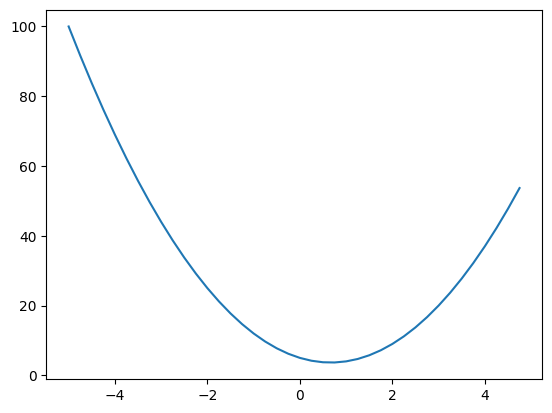

In [ ]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)

plt.plot(xs, ys)

**What is definition of derivative?**

Function is differentiable at point $x = a$ if following limit exists:<br><br>

$$ f'(a) = \lim_{h \to 0} \frac{f(a + h) - f(a)}{h} $$

Two main conditions - continuity and smoothness

**Continuity** means that function needs to be continuous at that point - no breaks, holes, jumps..<br>
**Smoothness** means function must have a unique tangent line at that point - no sharp corners or cusps


<br>
This means we can take extremly small value for $h$ such that ${h \to 0}$ and calculate approximation of slope at specific point



In [ ]:
# Let's try one small h
h = 0.0001
x = 3.0

# For x = 3.0 and small positive h we expect f(x+h) to be increased by small value - rate of increase is derivation at point x = 3.0
f(x + h)

# Exact value of that can be calculated using above formula
point_derivation = (f(x + h) - f(x))/h

print("Approximation of point derivation is: ", point_derivation)

Approximation of point derivation is:  14.000300000063248


In [ ]:
# Let's try a bit more complex example
a = 2.0
b = -3.0
c = 10.0
d = a*b + c

print(d)

4.0


In [ ]:
# Now let's get derivitive in respect to a -> similar for b and c -> for c slope is 1
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d = a*b + c

# check for a
a += h
da = a*b + c

print(f"d\t{d}\nda\t{da}\nslope\t{(da-d)/h}")


d	4.0
da	3.999699999999999
slope	-3.000000000010772


# Neural network implementation



To note... <br>
In Python, the __repr__ method is a special method that defines how an object should be represented as a string.
When you call repr(object) or simply type the object's name in an interactive interpreter, the $__repr__$ method is invoked to provide a string representation


In [ ]:
# Let's start with Value object

class Value:

  def __init__(self, data, _parents=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_parents) # stores Objects that it originates from
    self._op = _op # stores operation that created this node
    self.label = label # stores label for node

  # Used to provide desired string representation -> ideally string that can be used to recreate the object!
  def __repr__(self):
    return f"Value(data={self.data})"

  # Defines how should python use + operator whit objects of this class
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __radd__(self, other): # other + self
    return self.__add__(other)

  # Defines how should python use * operator whit objects of this class
  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
    return out

  # 2 * Value(5) in py -> 2.__mul__(a) which throws error so _rmul is defined to handle that, py checks _rmul for instructions if it exists
  def __rmul__(self, other): # other * self
    return self.__mul__(other)

  def __neg__(self):
    return self * -1

  def __sub__(self, other):
    return self + (-other)

  def __rsub__(self, other):
    return other + (-self)

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
      self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward
    return out

  def __truediv__(self, other): # self / other
    return self.__mul__(other**-1)

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad

    out._backward = _backward
    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out


  def backward(self):
    # Topological sort
    topo = []
    visited = set()

    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)


    build_topo(self)


    self.grad = 1.0
    for node in reversed(topo):
      node._backward()


In [ ]:
# Visualization of graphs
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()

  def build(v):
    if v not in nodes:
      nodes.add(v)
      for parent in v._prev:
        edges.add((parent, v))
        build(parent)

  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR', 'bgcolor': 'green'}) # TB -> top to bottom, also LR, RL, BT possible

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n)) # returns a unique id for the specified object (object's memory address)

    # for any value in graph, create rectengular ('record') node
    dot.node(name=uid, label= f"{{ {n.label} | value: {n.data:.4f} | grad: {n.grad:.4f} }}", shape='record')

    if n._op: # if this object is result of operation, create op node of it
      dot.node(name=uid + n._op, label = n._op)
      dot.edge(uid + n._op, uid)


  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot



To note... <br><br>
The id() function returns a unique id for the specified object.
All objects in Python have its own unique id.
The id is assigned to the object when it is created.
The id is the object's memory address, and will be different for each time you run the program. (except for some object that has a constant unique id, like integers from -5 to 256)

# Chain rule

$dz/dx = dz/dy * dy/dx$

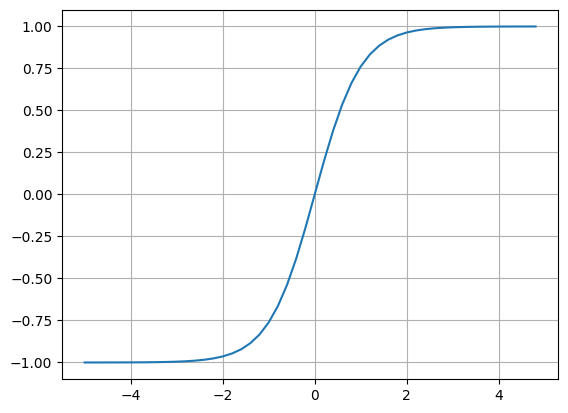

In [ ]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2))); plt.grid()

In [ ]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w1
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8814, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'


e = (2*n).exp()
o = (e - 1)/(e + 1); o.label = 'o'






In [ ]:
o.backward()


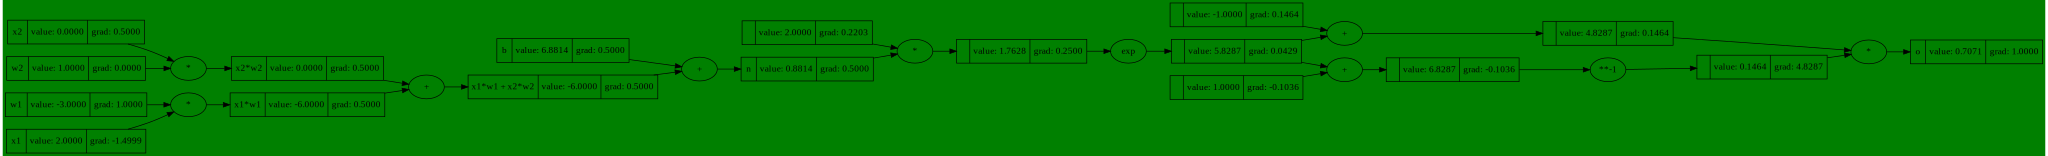

In [ ]:
draw_dot(o)

In [ ]:
import random
class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1, 1))

  # __call__ will be called when instance is called liek function ie. n = Neuron(2); n(2) so this n(2) will call __call__(2)
  def __call__(self, x):
    # w * x + b
    act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]


class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]



In [ ]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0] # desired targets




In [ ]:
for k in range(20):

  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum([(yp - yt)**2 for yt, yp in zip(ys, ypred)])

  # zero gradients
  for p in n.parameters():
    p.grad = 0.0

  # backward pass
  loss.backward()

  # update
  lr = 0.05
  for p in n.parameters():
    p.data += -lr * p.grad

  print(k, loss.data)

0 0.02717937373184981
1 0.02646625116354238
2 0.02578818117266233
3 0.02514266113222586
4 0.024527420821558735
5 0.023940396044077734
6 0.02337970576334536
7 0.02284363222118455
8 0.022330603593173393
9 0.02183917881113663
10 0.02136803424285185
11 0.02091595196884747
12 0.020481809437035817
13 0.020064570309701175
14 0.01966327634539037
15 0.019277040181597527
16 0.01890503890365588
17 0.0185465083016235
18 0.018200737730739592
19 0.017867065502672568


In [ ]:
ypred

[Value(data=0.8760689851134807),
 Value(data=-0.842421431890813),
 Value(data=-0.8914146865994031),
 Value(data=0.9072037050661966)]